# Graphs
> Embedding and classifying graphs with hyperbolic decision trees

Based on https://geomstats.github.io/notebooks/13_real_world_applications__graph_embedding_and_clustering_in_hyperbolic_space.html#

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install geomstats
!pip install networkx
!pip install torch
!pip install torch_geometric

In [3]:
import logging
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall


INFO: Using numpy backend


In [4]:
# Hyperparameters and data loading

gs.random.seed(1234)
dim = 2
max_epochs = 100
lr = 0.05
n_negative = 2
context_size = 1
karate_graph = load_karate_graph()


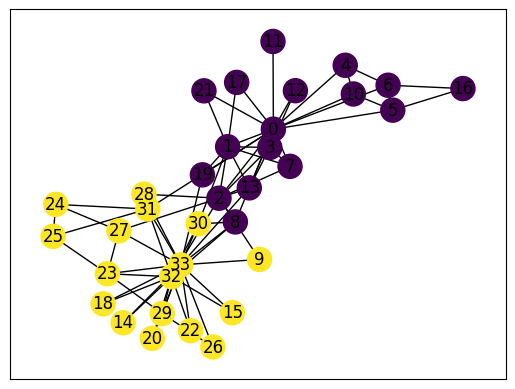

In [5]:
# Convert geomstats graph to networkx graph; visualize

karate_graph_nx = nx.Graph()
nodes = []
edges = []
for key in karate_graph.edges:
    nodes.append(key)
    for edge in karate_graph.edges[key]:
        edges.append([key, edge])
karate_graph_nx.add_nodes_from(nodes)
karate_graph_nx.add_edges_from(edges)

nx.draw_networkx(
    karate_graph_nx,
    with_labels=True,
    node_color=[karate_graph.labels[x][0] for x in nodes],
)


In [6]:
# Embed

hyperbolic_manifold = PoincareBall(2)


def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    log_map = PoincareBall(2).metric.log(point_b, point_a)

    return -2 * log_map


def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))


def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))


def loss(example_embedding, context_embedding, negative_embedding, manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim = negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance = manifold.metric.squared_dist(
        example_embedding, context_embedding
    )
    positive_loss = log_sigmoid(-positive_distance)

    reshaped_example_embedding = gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance = manifold.metric.squared_dist(
        reshaped_example_embedding, negative_embedding
    )
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad = -grad_log_sigmoid(-positive_distance)

    positive_distance_grad = grad_squared_distance(
        example_embedding, context_embedding
    )

    positive_grad = (
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)
        * positive_distance_grad
    )

    negative_distance_grad = grad_squared_distance(
        reshaped_example_embedding, negative_embedding
    )

    negative_distance = gs.to_ndarray(negative_distance, to_ndim=2, axis=-1)
    negative_log_sigmoid_grad = grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad


# Embed


def embed_graph(graph):
    nb_vertices_by_edges = [len(e_2) for _, e_2 in graph.edges.items()]

    embeddings = gs.random.normal(size=(graph.n_nodes, dim))
    embeddings = embeddings * 0.2
    random_walks = graph.random_walk()
    negative_table_parameter = 5
    negative_sampling_table = []

    for i, nb_v in enumerate(nb_vertices_by_edges):
        negative_sampling_table += (
            [i] * int((nb_v ** (3.0 / 4.0))) * negative_table_parameter
        )

    negative_sampling_table = gs.array(negative_sampling_table)

    for epoch in range(max_epochs):
        total_loss = []
        for path in random_walks:

            for example_index, one_path in enumerate(path):
                context_index = path[
                    max(0, example_index - context_size) : min(
                        example_index + context_size, len(path)
                    )
                ]
                negative_index = gs.random.randint(
                    negative_sampling_table.shape[0],
                    size=(len(context_index), n_negative),
                )
                negative_index = negative_sampling_table[negative_index]

                example_embedding = embeddings[one_path]
                for one_context_i, one_negative_i in zip(
                    context_index, negative_index
                ):
                    context_embedding = embeddings[one_context_i]
                    negative_embedding = embeddings[one_negative_i]
                    l, g_ex = loss(
                        example_embedding,
                        context_embedding,
                        negative_embedding,
                        hyperbolic_manifold,
                    )
                    total_loss.append(l)

                    example_to_update = embeddings[one_path]
                    embeddings[one_path] = hyperbolic_manifold.metric.exp(
                        -lr * g_ex, example_to_update
                    )
        logging.info(
            "iteration %d loss_value %f",
            epoch,
            sum(total_loss, 0) / len(total_loss),
        )

    return embeddings


embeddings = embed_graph(karate_graph)


INFO: iteration 0 loss_value 1.771314
INFO: iteration 1 loss_value 1.658352
INFO: iteration 2 loss_value 1.604607
INFO: iteration 3 loss_value 1.546119
INFO: iteration 4 loss_value 1.506840
INFO: iteration 5 loss_value 1.437123
INFO: iteration 6 loss_value 1.405791
INFO: iteration 7 loss_value 1.378170
INFO: iteration 8 loss_value 1.369926
INFO: iteration 9 loss_value 1.359530
INFO: iteration 10 loss_value 1.378218
INFO: iteration 11 loss_value 1.388711
INFO: iteration 12 loss_value 1.318382
INFO: iteration 13 loss_value 1.299767
INFO: iteration 14 loss_value 1.328728
INFO: iteration 15 loss_value 1.301325
INFO: iteration 16 loss_value 1.300106
INFO: iteration 17 loss_value 1.287544
INFO: iteration 18 loss_value 1.288304
INFO: iteration 19 loss_value 1.326081
INFO: iteration 20 loss_value 1.298692
INFO: iteration 21 loss_value 1.261768
INFO: iteration 22 loss_value 1.248945
INFO: iteration 23 loss_value 1.262734
INFO: iteration 24 loss_value 1.321558
INFO: iteration 25 loss_value 1.263

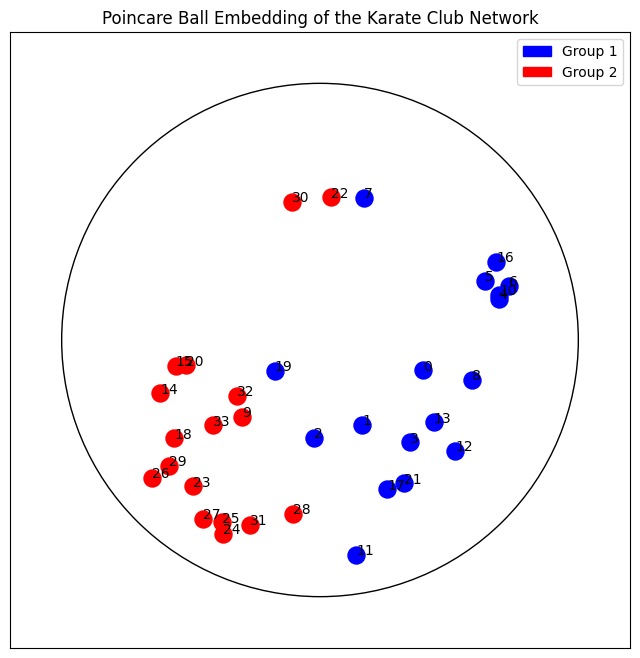

In [7]:
import matplotlib.patches as mpatches


def plot_graph(embeddings):
    colors = {1: "b", 2: "r"}
    group_1 = mpatches.Patch(color=colors[1], label="Group 1")
    group_2 = mpatches.Patch(color=colors[2], label="Group 2")

    circle = visualization.PoincareDisk(coords_type="ball")

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    circle.set_ax(ax)
    circle.draw(ax=ax)
    for i_embedding, embedding in enumerate(embeddings):
        x = embedding[0]
        y = embedding[1]
        pt_id = i_embedding
        plt.scatter(x, y, c=colors[karate_graph.labels[pt_id][0]], s=150)
        ax.annotate(pt_id, (x, y))

    plt.tick_params(which="both")
    plt.title("Poincare Ball Embedding of the Karate Club Network")
    plt.legend(handles=[group_1, group_2])
    plt.show()


plot_graph(embeddings)


INFO: iteration 0 loss_value 1.879719
INFO: iteration 1 loss_value 1.764710
INFO: iteration 2 loss_value 1.678932
INFO: iteration 3 loss_value 1.693109
INFO: iteration 4 loss_value 1.592424
INFO: iteration 5 loss_value 1.532137
INFO: iteration 6 loss_value 1.485895
INFO: iteration 7 loss_value 1.427980
INFO: iteration 8 loss_value 1.433133
INFO: iteration 9 loss_value 1.443724
INFO: iteration 10 loss_value 1.433814
INFO: iteration 11 loss_value 1.359036
INFO: iteration 12 loss_value 1.418302
INFO: iteration 13 loss_value 1.394516
INFO: iteration 14 loss_value 1.428955
INFO: iteration 15 loss_value 1.363950
INFO: iteration 16 loss_value 1.357374
INFO: iteration 17 loss_value 1.377301
INFO: iteration 18 loss_value 1.299857
INFO: iteration 19 loss_value 1.343722
INFO: iteration 20 loss_value 1.325223
INFO: iteration 21 loss_value 1.353097
INFO: iteration 22 loss_value 1.302103
INFO: iteration 23 loss_value 1.366539
INFO: iteration 24 loss_value 1.268152
INFO: iteration 25 loss_value 1.280

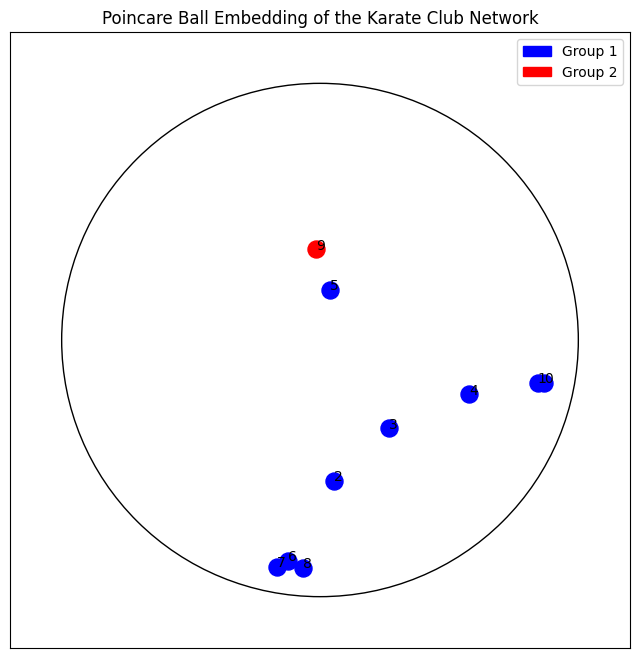

In [8]:
# Now try this with another dataset

from geomstats.datasets.utils import load_random_graph

randg = load_random_graph()
randg_embedding = embed_graph(randg)
plot_graph(randg_embedding)


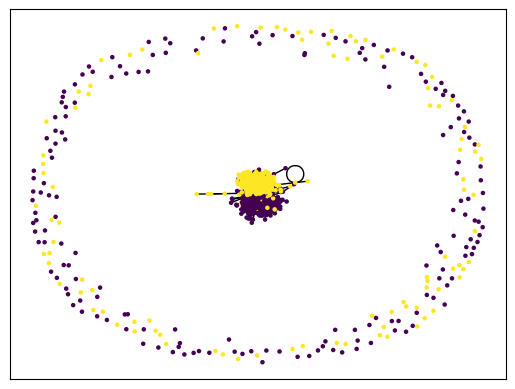

In [9]:
# # Embed polblogs


# def load_polblogs(path):
#     with open(path, "r") as f:
#         lines = f.readlines()
#     lines = lines[2:]
#     edges = []
#     for line in lines:
#         in_id, out_id, num_edges = line.split(" ")
#         for i in range(int(num_edges)):
#             edges.append([int(in_id) - 1, int(out_id) - 1])
#     edges = np.array(edges)
#     n_nodes = np.max(edges) + 1
#     graph = nx.Graph()
#     graph.add_nodes_from(range(n_nodes))
#     graph.add_edges_from(edges)
#     return graph

# polblogs_graph = load_polblogs(polblogs_path)

# nx.draw_networkx(polblogs_graph, with_labels=False, node_size=5)
import pandas as pd

adjacency = pd.read_table(
    "data/polblogs/raw/adjacency.tsv", header=None, usecols=[0, 1]
)
names = pd.read_table("data/polblogs/raw/names.tsv", header=None)
labels = pd.read_table("data/polblogs/raw/labels.tsv", header=None)
names_labels = pd.read_table("data/polblogs/raw/names_labels.tsv", header=None)

polblogs_graph = nx.from_pandas_edgelist(adjacency, source=0, target=1)
polblogs_graph.add_nodes_from(names.index)

nx.draw_networkx(
    polblogs_graph,
    with_labels=False,
    node_size=5,
    node_color=labels[0].reindex(polblogs_graph.nodes),  # Ordering
)


In [10]:
# Convert to geomstats graph

from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding


def nx_to_geomstats(graph, labels, drop_isolated=True):
    out_graph = load_karate_graph()  # Need a starter graph
    out_graph.n_nodes = graph.number_of_nodes()
    out_graph.n_edges = graph.number_of_edges()
    out_graph.edges = {
        node: list(graph.neighbors(node)) for node in graph.nodes
    }
    out_graph.labels = labels[0].reindex(polblogs_graph.nodes)

    if drop_isolated:
        for node in reversed(list(out_graph.edges.keys())):
            if len(out_graph.edges[node]) == 0:
                # del out_graph.edges[node]
                # del out_graph.labels[node]
                # out_graph.n_nodes -= 1
                # Add self-edge instead
                out_graph.edges[node] = [node]

    return out_graph


polblogs_graph_geom = nx_to_geomstats(polblogs_graph, labels)


INFO: Number of edges: 1490
INFO: Mean vertices by edges: 22.616778523489934


INFO: iteration 0 loss_value 2.828093
INFO: iteration 1 loss_value 2.456290
INFO: iteration 2 loss_value 2.375300
INFO: iteration 3 loss_value 2.313872
INFO: iteration 4 loss_value 2.245689
INFO: iteration 5 loss_value 2.166830
INFO: iteration 6 loss_value 2.105531
INFO: iteration 7 loss_value 2.042090
INFO: iteration 8 loss_value 1.994340
INFO: iteration 9 loss_value 1.948531
INFO: iteration 10 loss_value 1.925913
INFO: iteration 11 loss_value 1.915543
INFO: iteration 12 loss_value 1.884671
INFO: iteration 13 loss_value 1.878898
INFO: iteration 14 loss_value 1.872951
INFO: iteration 15 loss_value 1.857475
INFO: iteration 16 loss_value 1.850762
INFO: iteration 17 loss_value 1.843930
INFO: iteration 18 loss_value 1.843998
INFO: iteration 19 loss_value 1.837464
INFO: iteration 20 loss_value 1.829979
INFO: iteration 21 loss_value 1.828035
INFO: iteration 22 loss_value 1.827684
INFO: iteration 23 loss_value 1.819084
INFO: iteration 24 loss_value 1.813880
INFO: iteration 25 loss_value 1.811

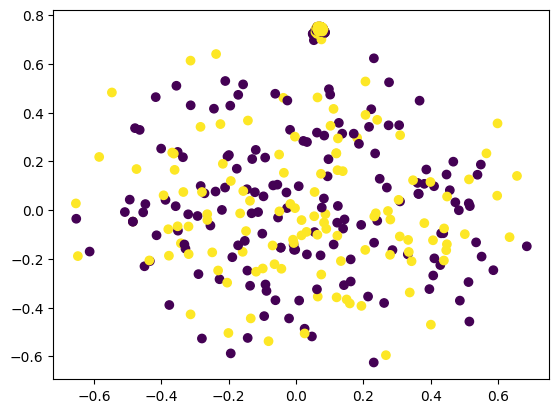

In [13]:
# Embed

hyp_emb = HyperbolicEmbedding(dim=8, n_negative=16, n_context=16, lr=0.01)
polblogs_graph_embedded = hyp_emb.embed(polblogs_graph_geom)

plt.scatter(
    polblogs_graph_embedded[:, 0],
    polblogs_graph_embedded[:, 1],
    c=polblogs_graph_geom.labels,
)


In [14]:
import pickle as pkl

with open("data/polblogs/processed/embed_8d.pkl", "wb") as f:
    pkl.dump(polblogs_graph_embedded, f)


In [15]:
# Convert to hyperboloid


def to_hyperboloid_points(poincare_pts):
    """
    Post: result.shape[1] == poincare_pts.shape[1] + 1
    """
    norm_sqd = (poincare_pts ** 2).sum(axis=1)
    N = poincare_pts.shape[1]
    result = np.zeros((poincare_pts.shape[0], N + 1), dtype=np.float64)
    result[:, :N] = (2.0 / (1 - norm_sqd))[:, np.newaxis] * poincare_pts
    result[:, N] = (1 + norm_sqd) / (1 - norm_sqd)
    return result


polblogs_graph_hyperboloid = to_hyperboloid_points(polblogs_graph_embedded)

polblogs_graph_hyperboloid.shape


(1490, 9)

In [16]:
# Try classifying hyp_emb now

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # SVM

from src.tree import HyperbolicDecisionTreeClassifier
from src.forest import HyperbolicRandomForestClassifier

# From https://github.com/drewwilimitis/hyperbolic-learning
from hyperbolic_learning.hyperbolic_svm.hsvm import LinearHSVM

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    polblogs_graph_hyperboloid,
    np.array(polblogs_graph_geom.labels),
    test_size=0.2,
    random_state=42,
)
# X_train, X_test, y_train, y_test = pkl.load(
#     open("data/polblogs/hsvm_data.pkl", "rb")
# )

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
NUM_ESTIMATORS = 100  # Keep it small, for speedup
JOBS = -1
USE_TQDM = True
args = dict(
    min_samples_split=MIN_SAMPLES,
    min_samples_leaf=MIN_SAMPLES,
    max_depth=MAX_DEPTH,
)

# Fit a regular decision tree
dt = DecisionTreeClassifier(**args)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(hyperbolic=True, **args)
hdt.fit(X_train, y_train)

# Control dt
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Sklearn random forest
rf = RandomForestClassifier(n_estimators=NUM_ESTIMATORS, **args)
rf.fit(X_train, y_train)

# Hyperbolic random forest
hrf = HyperbolicRandomForestClassifier(
    n_estimators=NUM_ESTIMATORS, hyperbolic=True, **args
)
hrf.fit(X_train, y_train, n_jobs=JOBS, use_tqdm=USE_TQDM)

# Control hrf
hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=NUM_ESTIMATORS, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train, n_jobs=JOBS, use_tqdm=USE_TQDM)

# Regular SVM
svm = SVC()
svm.fit(X_train, y_train)

# hSVM
hsvm = LinearHSVM(early_stopping=np.inf, num_epochs=1000)
hsvm.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    "",
    f"Random forest accuracy: {accuracy_score(y_test, rf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    "",
    f"SVM accuracy: {accuracy_score(y_test, svm.predict(X_test)):.3f}",
    f"hSVM accuracy: {accuracy_score(y_test, hsvm.predict(X_test)):.3f}",
    sep="\n",
)


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/phil/hdt/hyperbolic_learning/hyperbolic_svm/hsvm.py:84: RuntimeWarning: invalid value encountered in sqrt
  proj_w[0] = np.sqrt(np.sum(proj_w[1:] ** 2) - eps)


Regular decision tree accuracy: 0.624
Hyperbolic decision tree accuracy: 0.681
Hyperbolic decision tree accuracy (control): 0.540

Random forest accuracy: 0.674
Hyperbolic random forest accuracy: 0.718
Hyperbolic random forest accuracy (control): 0.537

SVM accuracy: 0.594
hSVM accuracy: 0.503


In [18]:
# This takes about 10 minutes

vals = pd.DataFrame(columns=["name", "trial", "score"])
for predictor, name in zip(
    [dt, hdt, hdt_control, rf, hrf, hrf_control, svm],
    [
        "Decision Tree",
        "Hyperbolic Decision Tree",
        "Control Decision Tree",
        "Random Forest",
        "Hyperbolic Random Forest",
        "Control Random Forest",
        "SVM",
    ],
):
    fit_params = {}
    if name in ["Hyperbolic Random Forest", "Control Random Forest"]:
        fit_params = {"use_tqdm": True, "n_jobs": -1}
    scores = cross_val_score(
        predictor,
        X_train,
        y_train,
        cv=10,
        fit_params=fit_params,
    )
    vals = pd.concat(
        [
            vals,
            pd.DataFrame(
                [[name, i, score] for i, score in enumerate(scores)],
                columns=["name", "trial", "score"],
            ),
        ]
    )

vals


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


,name,trial,score
0,Decision Tree,0,0.525000
1,Decision Tree,1,0.583333
2,Decision Tree,2,0.697479
3,Decision Tree,3,0.563025
4,Decision Tree,4,0.689076
...,...,...,...
5,SVM,5,0.613445
6,SVM,6,0.546218
7,SVM,7,0.647059
8,SVM,8,0.596639


In [19]:
# Can't use hsvm with cross_val_score, so do it manually:
splits = KFold(n_splits=10).split(X_train)
for split in splits:
    X_train_split, X_val_split = X_train[split[0]], X_train[split[1]]
    y_train_split, y_val_split = y_train[split[0]], y_train[split[1]]
    hsvm.fit(X_train_split, y_train_split)
    vals = pd.concat(
        [
            vals,
            pd.DataFrame(
                [
                    [
                        "Hyperbolic SVM",
                        i,
                        hsvm.score(X_val_split, y_val_split),
                    ]
                    for i in range(5)
                ],
                columns=["name", "trial", "score"],
            ),
        ]
    )
vals


/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/phil/hdt/hyperbolic_learning/hyperbolic_svm/hsvm.py:84: RuntimeWarning: invalid value encountered in sqrt
  proj_w[0] = np.sqrt(np.sum(proj_w[1:] ** 2) - eps)
/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, incre

,name,trial,score
0,Decision Tree,0,0.525000
1,Decision Tree,1,0.583333
2,Decision Tree,2,0.697479
3,Decision Tree,3,0.563025
4,Decision Tree,4,0.689076
...,...,...,...
0,Hyperbolic SVM,0,0.487395
1,Hyperbolic SVM,1,0.487395
2,Hyperbolic SVM,2,0.487395
3,Hyperbolic SVM,3,0.487395


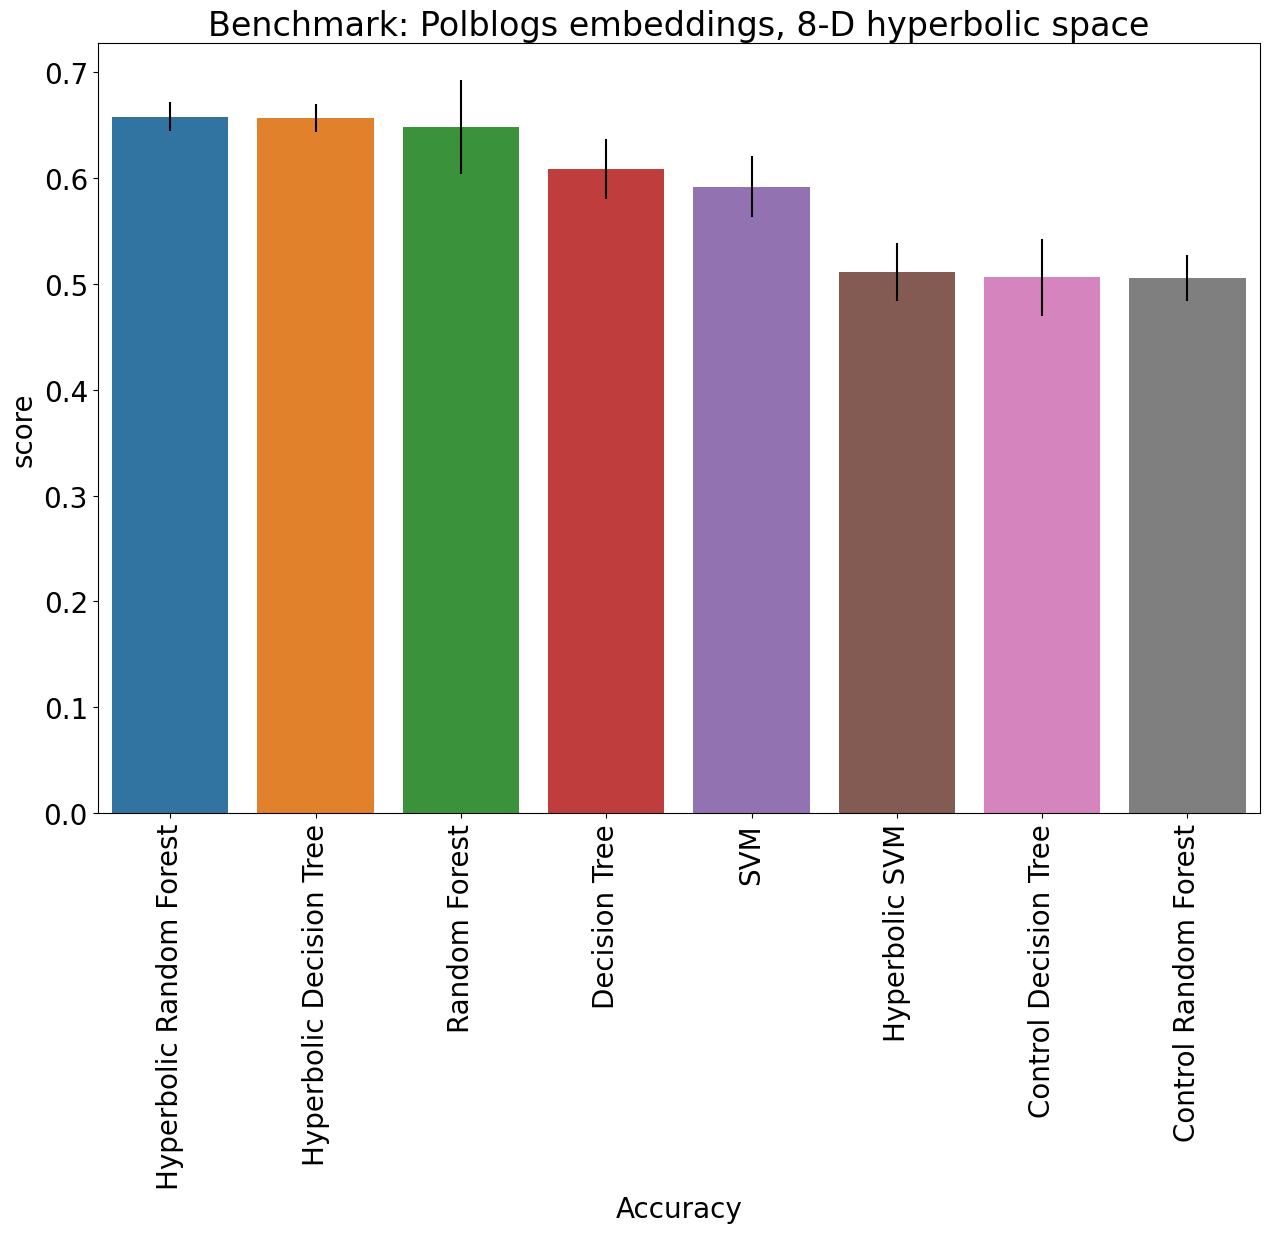

In [21]:
order = []

means = vals.groupby("name").mean()
stds = vals.groupby("name").std()

# Compute 95% confidence intervals
intervals = 1.96 * stds["score"] / np.sqrt(10)

# Sort by mean score
means = means.sort_values(by="score", ascending=False)
stds = stds.loc[means.index]

# fig = plt.figure(figsize=(15, 10))
# plt.barh(
#     means.index,
#     means.score,
#     xerr=intervals,
#     capsize=5,
# )
# # plt.xticks(rotation=90)

# # Add statistical significance stars
# for i, (mean1, interval1) in enumerate(zip(means.score, intervals)):
#     for j, (mean2, interval2) in enumerate(zip(means.score, intervals)):
#         if mean1 >

# Seaborn plot with stars
import seaborn as sns

fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(
    y=means.score,
    x=means.index,
    yerr=intervals,
    capsize=5,
    order=means.index,
)
plt.xlabel("Accuracy")
plt.xticks(rotation=90)
# plt.ylabel("Classifier")
plt.title("Benchmark: Polblogs embeddings, 8-D hyperbolic space")

# Make background transparent
fig.patch.set_alpha(0.0)

# Bigger fonts
plt.rcParams.update({"font.size": 20})
